using PyTorch version: 2.11.0.dev20260107+cu128, Device: cuda
Epoch [20/2000], Loss: 0.000922
Epoch [40/2000], Loss: 0.000913
Epoch [60/2000], Loss: 0.000927
Epoch [80/2000], Loss: 0.000938
Epoch [100/2000], Loss: 0.000954
Epoch [120/2000], Loss: 0.000974
Epoch [140/2000], Loss: 0.000977
Epoch [160/2000], Loss: 0.000961
Epoch [180/2000], Loss: 0.000935
Epoch [200/2000], Loss: 0.000911
Epoch [220/2000], Loss: 0.000885
Epoch [240/2000], Loss: 0.000860
Epoch [260/2000], Loss: 0.000837
Epoch [280/2000], Loss: 0.000817
Epoch [300/2000], Loss: 0.000801
Epoch [320/2000], Loss: 0.000787
Epoch [340/2000], Loss: 0.000775
Epoch [360/2000], Loss: 0.000763
Epoch [380/2000], Loss: 0.000753
Epoch [400/2000], Loss: 0.000745
Epoch [420/2000], Loss: 0.000737
Epoch [440/2000], Loss: 0.000730
Epoch [460/2000], Loss: 0.000724
Epoch [480/2000], Loss: 0.000716
Epoch [500/2000], Loss: 0.000710
Epoch [520/2000], Loss: 0.000704
Epoch [540/2000], Loss: 0.000699
Epoch [560/2000], Loss: 0.000693
Epoch [580/2000], 

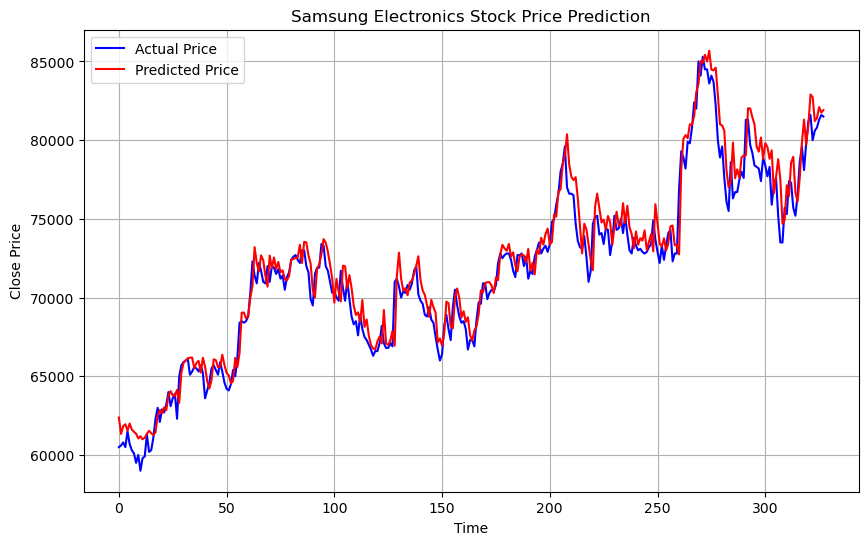

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt

# 1. MinMaxScaler 직접 구현
class MinMaxScaler:
    def __init__(self):
        self.min = None
        self.max = None

    def fit_transform(self, data):
        # 데이터가 DataFrame인 경우 numpy로 변환
        if hasattr(data, 'values'):
            data = data     .values
        
        self.min = data.min(axis=0)
        self.max = data.max(axis=0)
        
        # 0으로 나누기 방지 (분모가 0이면 1로 대체)
        denom = self.max - self.min
        denom[denom == 0] = 1.0
        
        return (data - self.min) / denom

    def inverse_transform(self, data):
        # 정규화된 데이터를 다시 원래 스케일로 복구
        return data * (self.max - self.min) + self.min

# 장치 설정
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'using PyTorch version: {torch.__version__}, Device: {device}')

# 하이퍼파라미터
FEATURE_NUMS = 4    # 입력 컬럼 개수 (Open, High, Low, Volume)
SEQ_LENGTH = 5      # 5일치 데이터를 보고
HIDDEN_SIZE = 4     # hidden state 개수
NUM_LAYERS = 1      # LSTM 레이어 층
LEARNING_RATE = 1e-3
BATCH_SIZE = 20
EPOCH = 2000

# 2. 데이터 로드 및 전처리
df = fdr.DataReader('005930', '2020-01-01', '2024-06-30')
df = df[['Open', 'High', 'Low', 'Volume', 'Close']]

# 이 코드를 추가하여 모든 열을 실수형으로 변환합니다.
df = df.astype(float)

split = int(0.7 * len(df))
train_df = df[:split].copy()
test_df = df[split:].copy()

# 스케일러 적용
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Feature 스케일링 (Close 제외)
train_df.iloc[:, :-1] = scaler_x.fit_transform(train_df.iloc[:, :-1])
test_df.iloc[:, :-1] = scaler_x.fit_transform(test_df.iloc[:, :-1])

# Label 스케일링 (Close)
train_df.iloc[:, [-1]] = scaler_y.fit_transform(train_df.iloc[:, [-1]])
test_df.iloc[:, [-1]] = scaler_y.fit_transform(test_df.iloc[:, [-1]])

# 3. 시퀀스 데이터 생성 함수
def MakeSeqNumpyData(data, seq_length):
    x_seq_list = []
    y_seq_list = []

    for i in range(len(data) - seq_length):
        x_seq_list.append(data[i:i+seq_length, :-1])  # 5일치 Feature
        y_seq_list.append(data[i+seq_length, [-1]])   # 다음날 Close
    
    return np.array(x_seq_list), np.array(y_seq_list)

x_train_data, y_train_data = MakeSeqNumpyData(np.array(train_df), SEQ_LENGTH)
x_test_data, y_test_data = MakeSeqNumpyData(np.array(test_df), SEQ_LENGTH)

# 텐서 변환 및 장치 할당
x_train_tensor = torch.FloatTensor(x_train_data).to(device)
y_train_tensor = torch.FloatTensor(y_train_data).to(device)
x_test_tensor = torch.FloatTensor(x_test_data).to(device)
y_test_tensor = torch.FloatTensor(y_test_data).to(device)

# Dataset & DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 4. LSTM 모델 정의
class MyLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, data):
        # 초기 hidden state와 cell state 설정
        h0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size).to(device)

        outputs, _ = self.lstm(data, (h0, c0))
        last_hs = outputs[:, -1, :]  # 마지막 시점의 hidden state만 추출
        prediction = self.fc(last_hs)
        return prediction

model = MyLSTMModel(FEATURE_NUMS, HIDDEN_SIZE, NUM_LAYERS).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 5. 모델 학습 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train()
    train_loss_sum = 0
    total_train_batch = len(dataloader)

    for inputs, labels in dataloader:
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

    return train_loss_sum / total_train_batch

# 학습 실행
train_loss_list = []
for epoch in range(EPOCH):
    avg_loss = model_train(train_loader, model, loss_function, optimizer)
    train_loss_list.append(avg_loss)
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{EPOCH}], Loss: {avg_loss:.6f}')

# 6. 예측 및 결과 시각화
model.eval()
with torch.no_grad():
    test_pred_tensor = model(x_test_tensor)
    test_pred_numpy = test_pred_tensor.cpu().numpy()
    pred_inverse = scaler_y.inverse_transform(test_pred_numpy)

    y_test_numpy = y_test_tensor.cpu().numpy()
    y_test_inverse = scaler_y.inverse_transform(y_test_numpy)

plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label="Actual Price", color='blue')
plt.plot(pred_inverse, label="Predicted Price", color='red')
plt.title("Samsung Electronics Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()